# Problem Description
The goal of this notebook is to build an Unsupervised learning model for clustering diabetes based on various other features including but not limited to blood pressure, cholesterol, BMI, age, and general health. 

## Data
The data is sourced from https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators.

See https://www.cdc.gov/brfss/annual_data/annual_2014.html as well for more information about codes.

## Importing libraries

In [223]:
import numpy as np
import pandas as pd
import re
import string
from collections import  Counter
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix, davies_bouldin_score, calinski_harabasz_score

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [170]:
# Load data
df = pd.read_csv("data/diabetes_binary_health_indicators_BRFSS2015.csv")

### Exploratory Data Analysis

In [4]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [7]:
# Check for missing data
df.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Splitting people who do have diabetes and those who don"t for ease.

In [171]:
df_yes_diabetes = df[df["Diabetes_binary"] == 1]
df_no_diabetes = df[df["Diabetes_binary"] == 0]

In [ ]:
import random
# For more colorful displays
seaborn_palettes = [
    "deep", "muted", "bright", "pastel", "dark", "colorblind",
    "husl", "hls", "cool", "hot", "spring", "summer", "autumn", "winter",
    "Blues", "BrBG", "BuGn", "BuPu", "CMRmap", "GnBu", "Greens", "Greys",
    "OrRd", "Oranges", "PRGn", "PiYG", "PuBu", "PuBuGn", "PuOr", "PuRd",
    "Purples", "RdBu", "RdGy", "RdPu", "RdYlBu", "RdYlGn", "Reds", "Spectral",
    "Wistia", "YlGn", "YlGnBu", "YlOrBr", "YlOrRd"
]
def countplot_feature_by_diabetes(feature):
    """
    Helper to plot a countplot feature by diabetes
    """
    ax = sns.countplot(df, x="Diabetes_binary", hue=feature, palette=seaborn_palettes[random.randint(0, len(seaborn_palettes)-1)])
    ax.set(title=f"Diabetes status by {feature}", xlabel="Diabetes Status", ylabel="Count")
    ax.set_xticks(ax.get_xticks())
    ax.xaxis.set_ticklabels(["No Diabetes", "Has Diabetes"])
    ax.legend(title=feature)
    return ax

In [74]:
df_yes_diabetes["Age"]

8          9.0
10        13.0
13        11.0
17         7.0
23        13.0
          ... 
253659     6.0
253668    10.0
253670    13.0
253676    11.0
253679     9.0
Name: Age, Length: 35346, dtype: float64

### Age

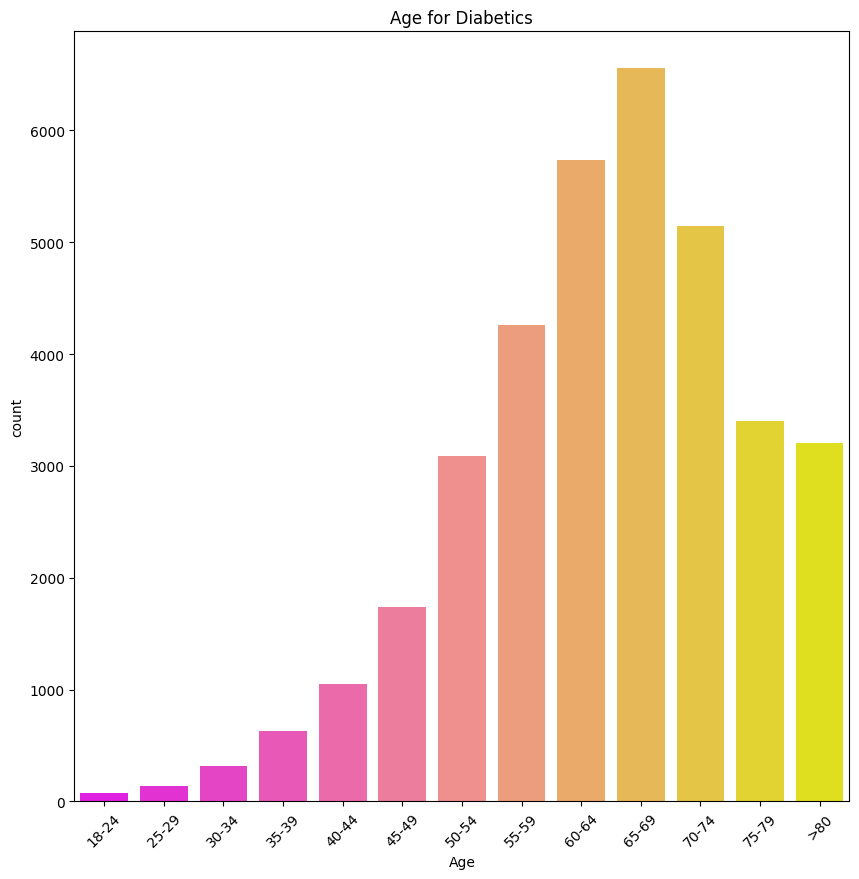

In [86]:
fig = plt.figure(figsize=(10,10))
ax = sns.countplot(df_yes_diabetes, x="Age", hue="Age", legend=False,palette="spring")
ax.set(title="Age for Diabetics")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", ">80"], rotation = 45)
plt.show()

### BMI

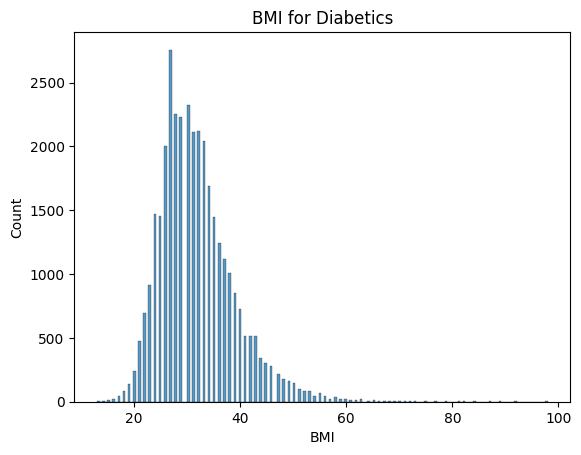

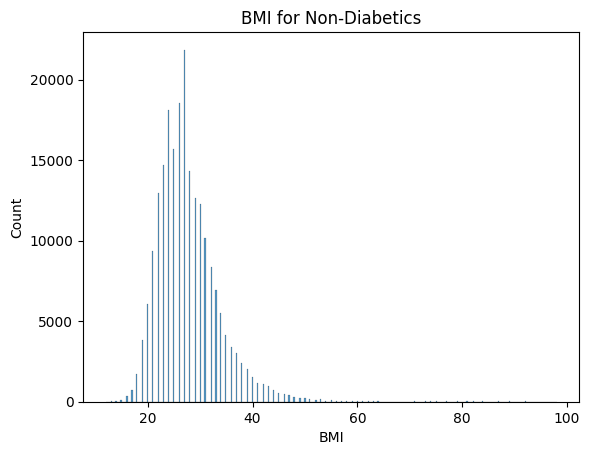

In [92]:
sns.histplot(df_yes_diabetes, x="BMI").set(title="BMI for Diabetics")
plt.show()

sns.histplot(df_no_diabetes, x="BMI").set(title="BMI for Non-Diabetics")
plt.show()

### Income

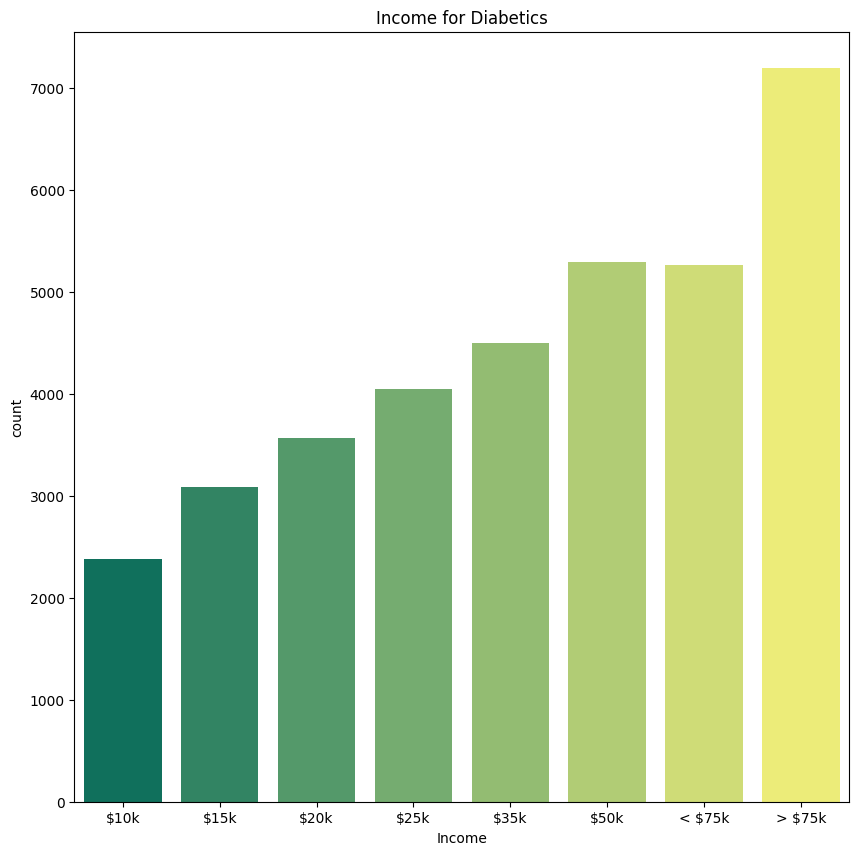

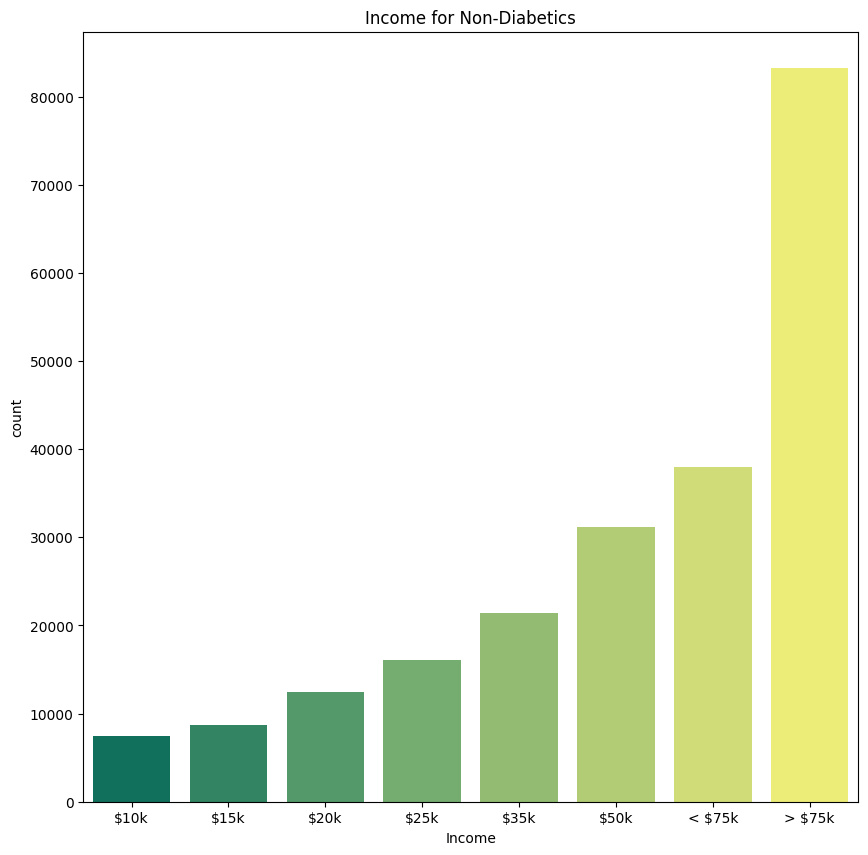

In [93]:
fig = plt.figure(figsize=(10,10))
ax = sns.countplot(df_yes_diabetes, x="Income", hue="Income", legend=False,palette="summer")
ax.set(title="Income for Diabetics")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["$10k", "$15k", "$20k", "$25k", "$35k", "$50k", "< $75k", "> $75k"])
plt.show()

fig = plt.figure(figsize=(10,10))
ax = sns.countplot(df_no_diabetes, x="Income", hue="Income", legend=False,palette="summer")
ax.set(title="Income for Non-Diabetics")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["$10k", "$15k", "$20k", "$25k", "$35k", "$50k", "< $75k", "> $75k"])
plt.show()

### Gender

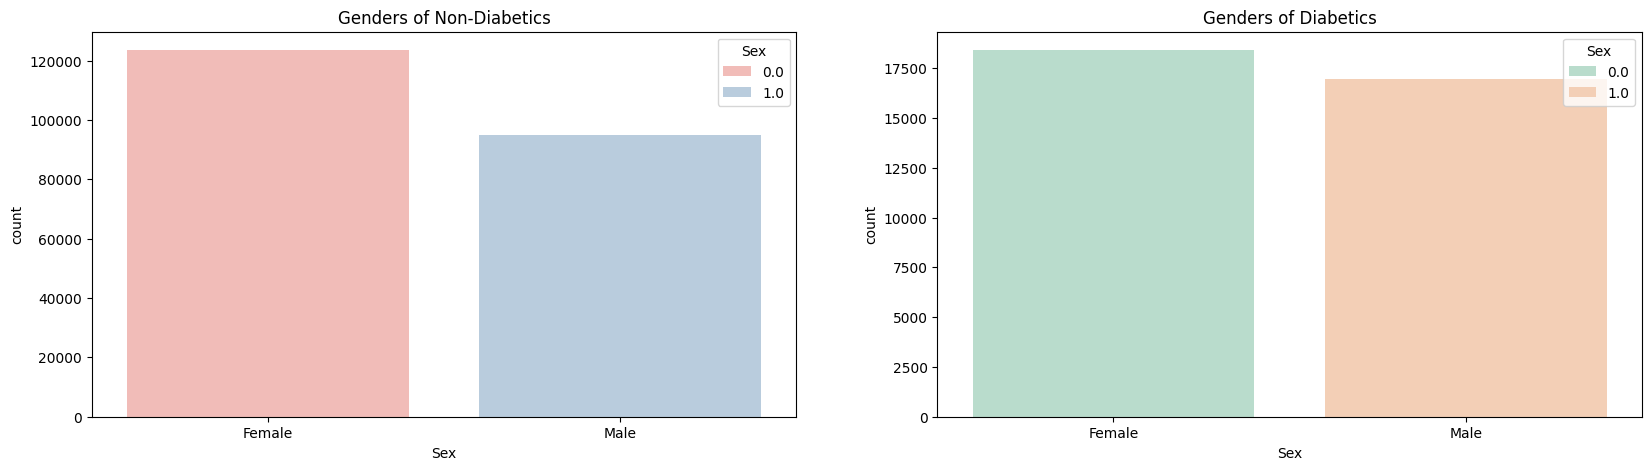

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1 = sns.countplot(df_no_diabetes, x="Sex", ax=ax1, hue="Sex", palette="Pastel1")
ax1.set(title="Genders of Non-Diabetics")
ax1.set_xticks(ax1.get_xticks())
ax1.xaxis.set_ticklabels(["Female", "Male"])

ax2 = sns.countplot(df_yes_diabetes, x="Sex", ax=ax2, hue="Sex", palette="Pastel2")
ax2.set(title="Genders of Diabetics")
ax2.set_xticks(ax2.get_xticks())
ax2.xaxis.set_ticklabels(["Female", "Male"])
plt.show()

### Other Features Plotted

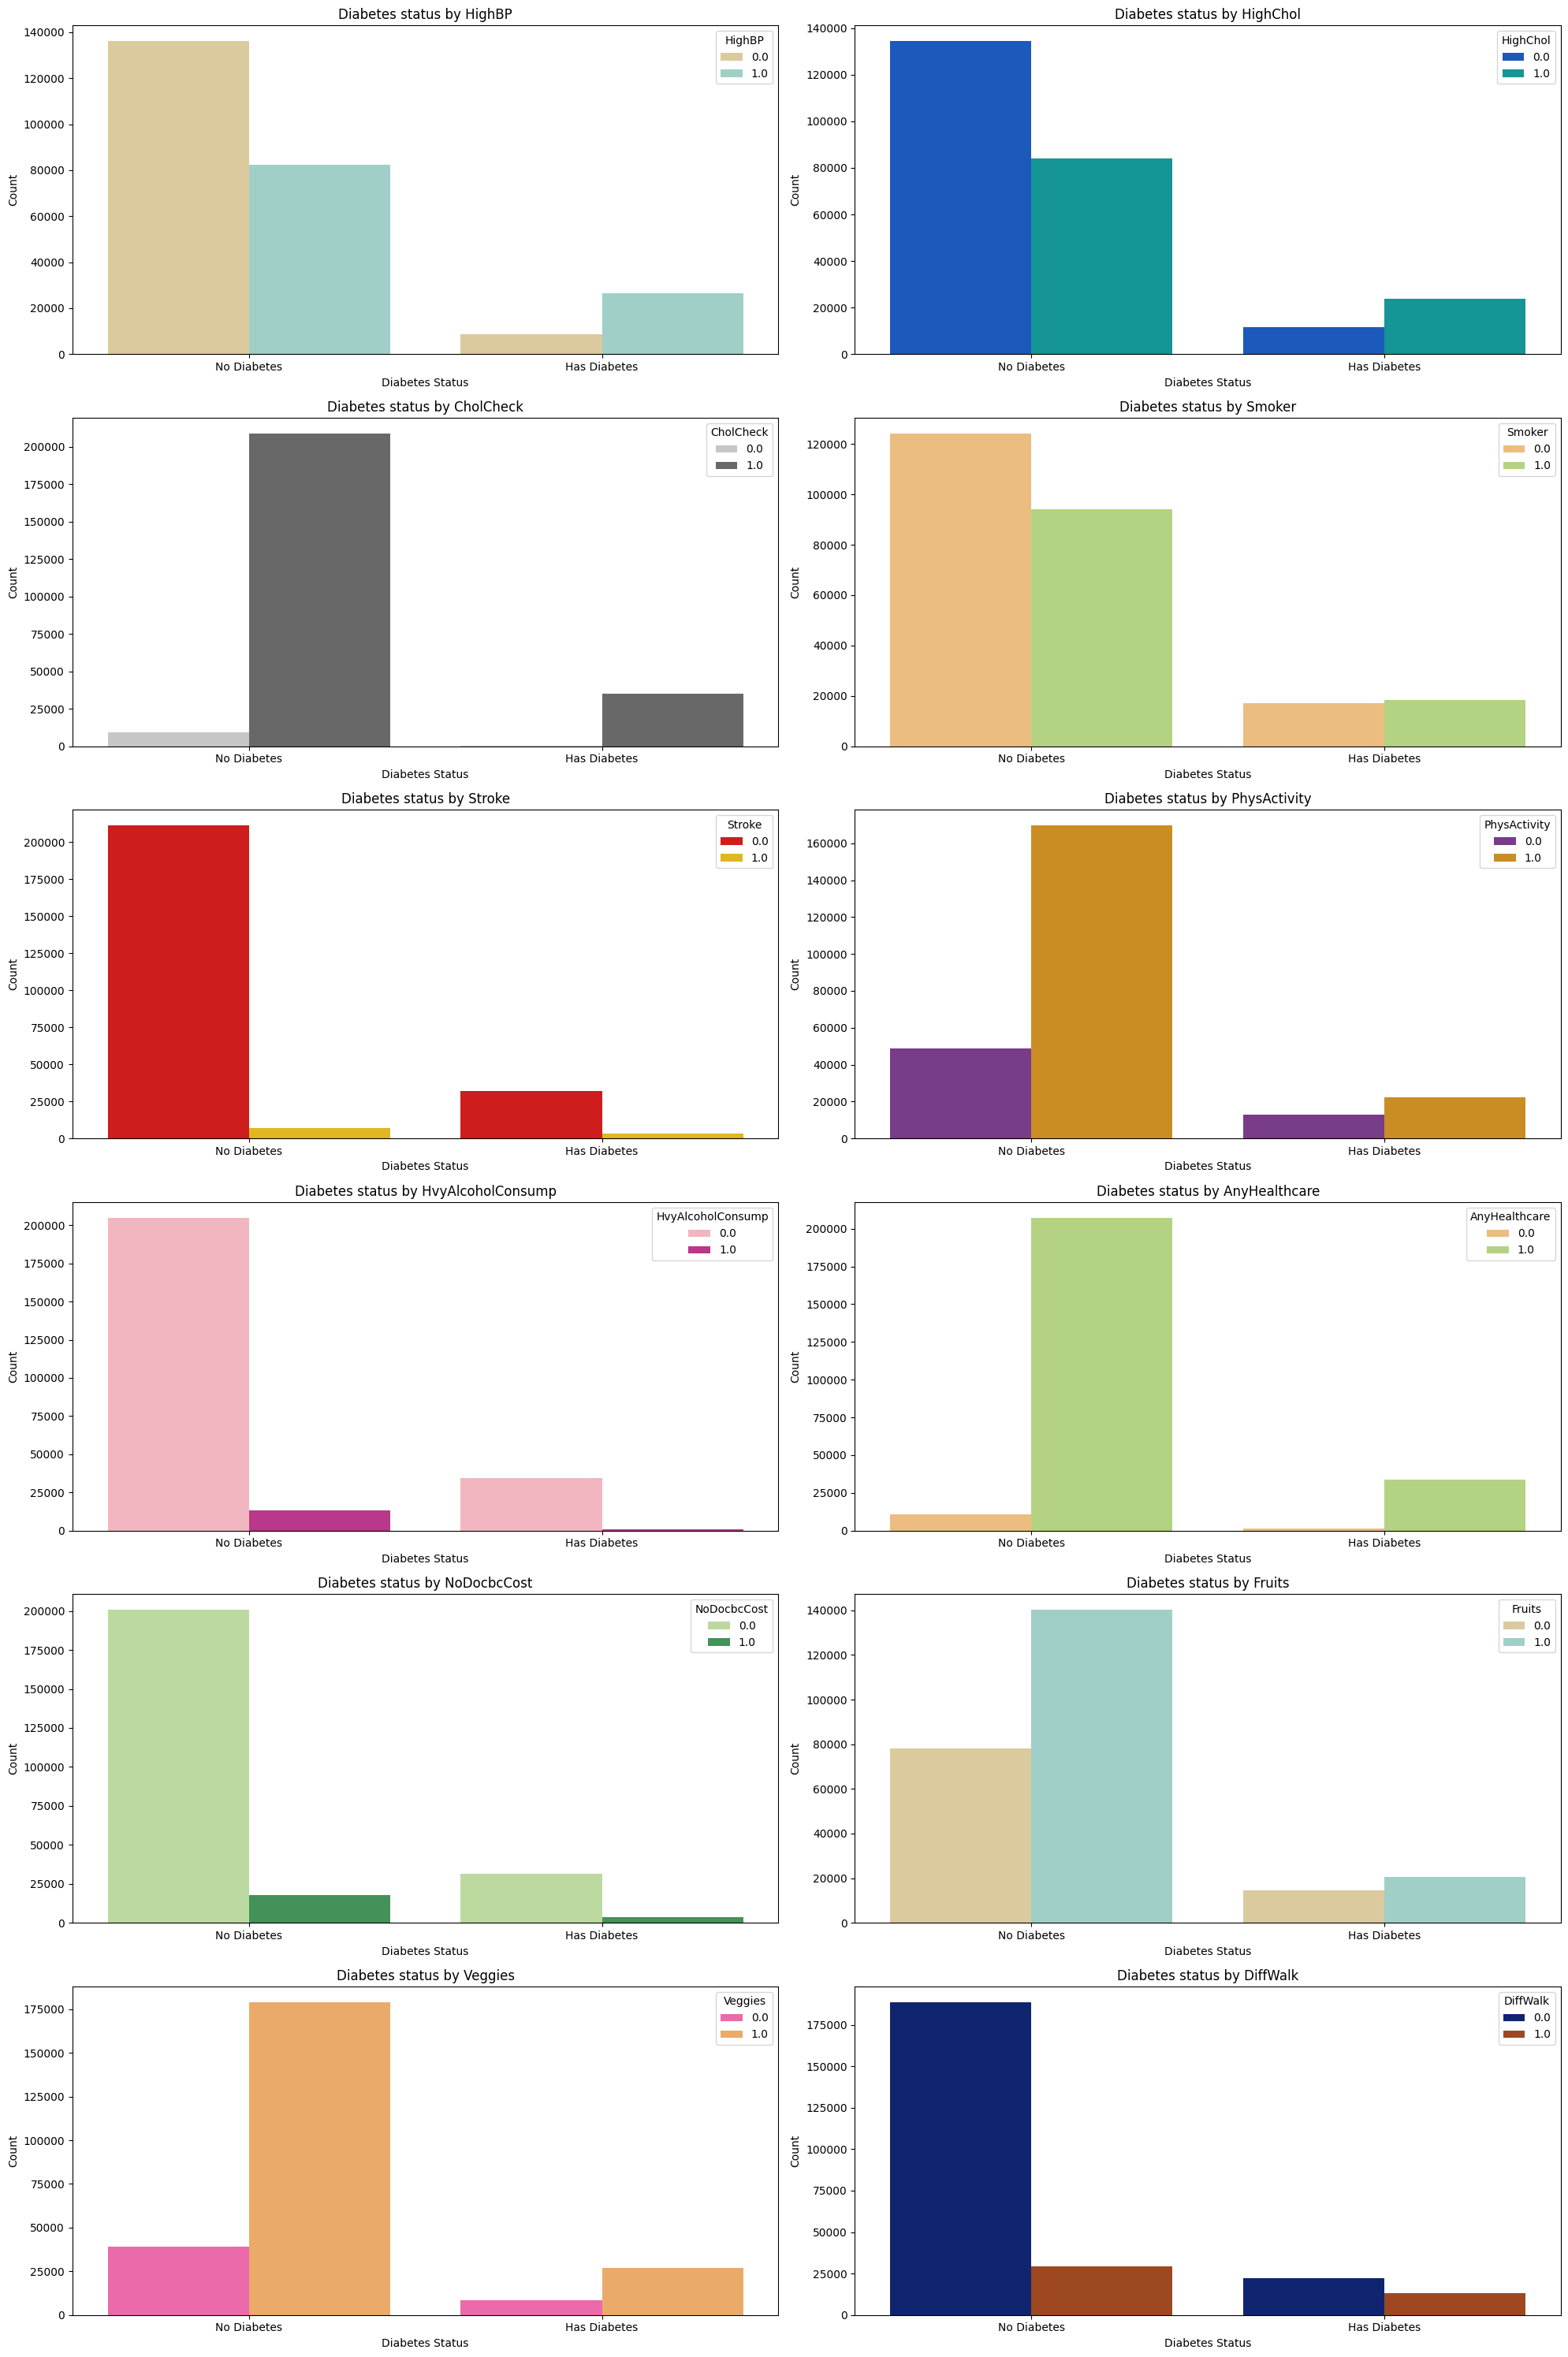

In [99]:
other_features = ["HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", "PhysActivity", "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", "Fruits", "Veggies", "DiffWalk"]
# for better display
rows = 6
cols = 2
c = 1
fig = plt.figure(figsize=(20, 30))
for feature in other_features:
    plt.subplot(rows, cols, c)
    ax = countplot_feature_by_diabetes(feature)
    c += 1
plt.tight_layout()
plt.show()

## Correlation Matrix

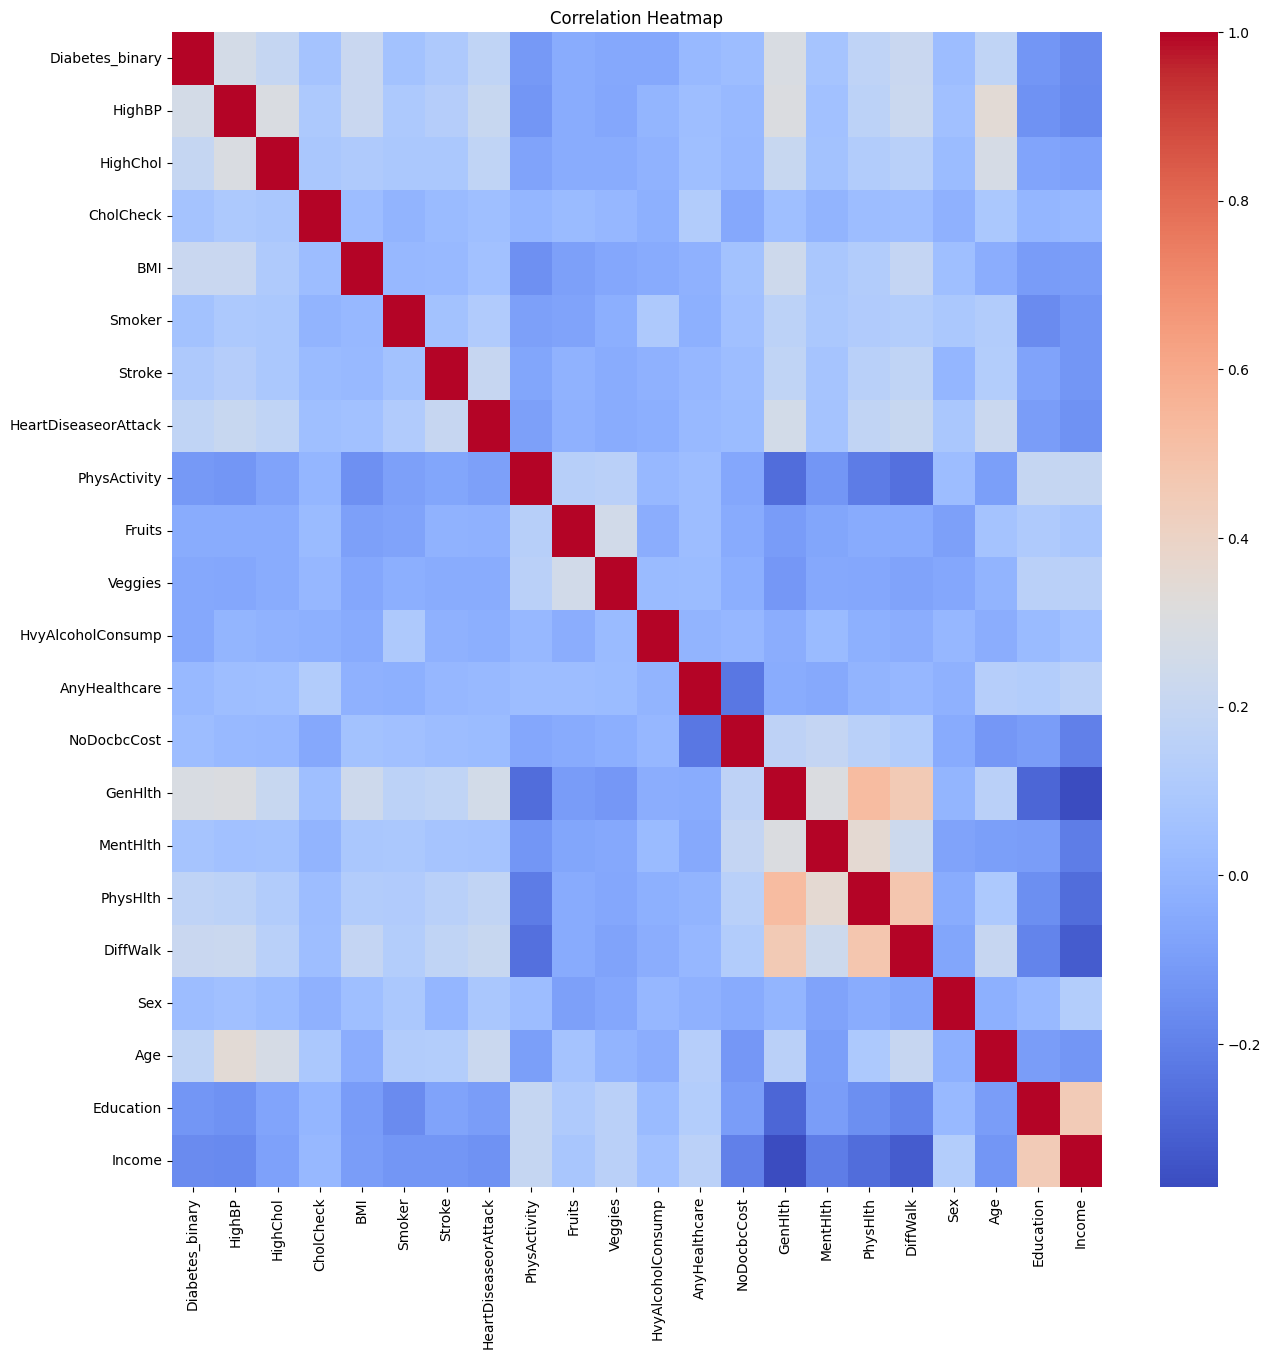

In [177]:
correlation = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(data=correlation, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

### Analysis

- Diabetics are mostly from 50+ years old.
- Diabetics generally have a higher BMI.
- Diabetics have higher blood pressure and cholesterol.
- Smoking appears to have little to no affect on diabetes status.
- Diabetics tend to never have a stroke.
- Physical activity seems to have no affect on diabetes.
- Heavy alcohol consumption has no affect on diabetes.
- Eating fruits and veggies or not having a doctor doesn't seem to correlate with having diabetes.
- Common health issues seem to be heavy correlated to having diabetes.

### Unsupervised Model
Using K-means clustering to group similar data together.

In [172]:
df_yes_diabetes.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [196]:

# Categorical/binary features
cat_features = ['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']

# Numerical features
numeric_features = ['GenHlth',
       'MentHlth', 'PhysHlth', 'Age', 'Education',
       'Income', 'BMI']

In [202]:
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(sparse_output=False), cat_features)
], remainder='passthrough')
X = column_transformer.fit_transform(df)

[[1. 0. 0. ... 9. 4. 3.]
 [1. 0. 1. ... 7. 6. 1.]
 [1. 0. 0. ... 9. 4. 8.]
 ...
 [1. 0. 1. ... 2. 5. 2.]
 [1. 0. 0. ... 7. 5. 1.]
 [0. 1. 0. ... 9. 6. 2.]]


In [203]:
encoded_feature_names = column_transformer.named_transformers_['encoder'].get_feature_names_out(cat_features)
feature_names = list(encoded_feature_names) + numeric_features
print(feature_names)

['Diabetes_binary_0.0', 'Diabetes_binary_1.0', 'HighBP_0.0', 'HighBP_1.0', 'HighChol_0.0', 'HighChol_1.0', 'CholCheck_0.0', 'CholCheck_1.0', 'Smoker_0.0', 'Smoker_1.0', 'Stroke_0.0', 'Stroke_1.0', 'HeartDiseaseorAttack_0.0', 'HeartDiseaseorAttack_1.0', 'PhysActivity_0.0', 'PhysActivity_1.0', 'Fruits_0.0', 'Fruits_1.0', 'Veggies_0.0', 'Veggies_1.0', 'HvyAlcoholConsump_0.0', 'HvyAlcoholConsump_1.0', 'AnyHealthcare_0.0', 'AnyHealthcare_1.0', 'NoDocbcCost_0.0', 'NoDocbcCost_1.0', 'DiffWalk_0.0', 'DiffWalk_1.0', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income', 'BMI']


In [207]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The dataset is preprocessed through the following steps:
- Converting categorical features into numeric representations.
- Merging and organizing feature names into labeled formats.
- Scaling and standardizing the features for use in clustering or other unsupervised learning methods.

These steps ensure the data is well-structured, fully numeric, and appropriately normalized for advanced analysis.

# KMeans Clustering

The code below uses the Elbow Method to identify the ideal number of clusters (k) for K-Means Clustering.

By plotting the number of clusters (k) against the within-cluster sum of squares (WCSS), the Elbow Method highlights the point where the inertia improvement begins to plateau. This "elbow" signifies the most suitable k value.

Using this technique guarantees clustering outcomes that are both precise and easy to interpret.

In [205]:
wcss = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

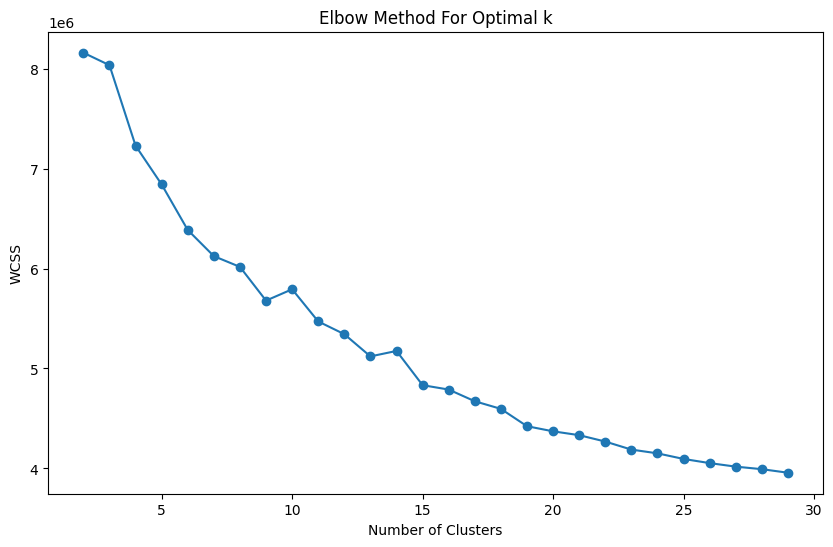

In [206]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 30), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

The optimal number of clusters (k) for KMeans clustering seems to be around 13-16. We'll use 15.

In [235]:
# optimal_k = 15
# Using 2 for ease for diabetes and no diabetes
kmeans = KMeans(n_clusters=2, random_state=123)
kmeans_labels = kmeans.fit_predict(X_scaled)

In [236]:
df['Cluster'] = kmeans_labels

### PCA Visualizations

In [237]:
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled)

In [238]:
# Create a DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

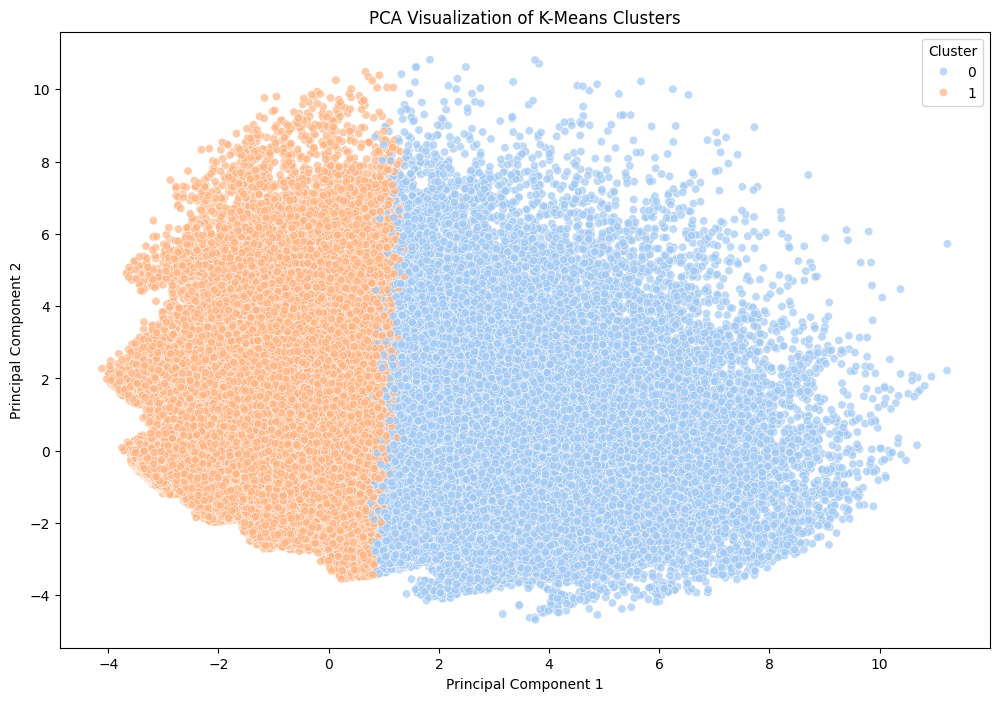

In [240]:
# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='pastel', alpha=0.7)
plt.title('PCA Visualization of K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [233]:
silhouette = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans_labels)

print("\nCluster Quality Metrics:")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")


Cluster Quality Metrics:
Silhouette Score: 0.108
Davies-Bouldin Score: 1.853
Calinski-Harabasz Index: 16119.994


Cluster Quality Metrics:

| K  | Silhouette Score | Davies-Bouldin Score | Calinski-Harabasz Index |
| -- | ---------------- | -------------------- | ----------------------- |
| 2  | 0.193            | 2.658                | 30258.507               |
| 15 | 0.108            | 1.853                | 16119.994               |



A comparison of the clustering results based on three key metrics:

Silhouette Score (Higher is better; range -1 to 1)

Davies-Bouldin Score (Lower is better)

Calinski-Harabasz Index (Higher is better; inter-cluster compactness and separation)

k=2 is the best for all three indicating that the clusters are well separated and compacted.


### Analyze Clusters

In [243]:
# Check cluster means by categorical features
cluster_means = df.groupby('Cluster')[cat_features].mean()
print("\nCluster Means:")
print(cluster_means)


Cluster Means:
         Diabetes_binary    HighBP  HighChol  CholCheck    Smoker    Stroke  \
Cluster                                                                       
0               0.400466  0.777452  0.682483   0.984895  0.607882  0.126085   
1               0.036579  0.291888  0.322457   0.953924  0.378355  0.006921   

         HeartDiseaseorAttack  PhysActivity    Fruits   Veggies  \
Cluster                                                           
0                    0.285535      0.512634  0.539478  0.701273   
1                    0.018891      0.852521  0.671550  0.854762   

         HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  DiffWalk  
Cluster                                                           
0                 0.035849       0.945626     0.152721  0.542871  
1                 0.064204       0.953188     0.057205  0.020802  


### Categorical Analysis
- Cluster 0: Group of people who tend to have diabetes.
- Cluster 1: Group of people who rarely have diabetes.

#### High Blood Pressure:
- People with diabetes tend to have a higher blood pressure (0.77) than those without diabetes (0.29).
- People without diabetes have a much lower chance of having high blood pressure.

#### High Cholesterol: 
- People with diabetes tend to have a higher cholesterol (0.68) than those without diabetes (0.32).
- People without diabetes have a much lower chance of having high cholesterol.

#### Cholesterol Check:
- Both groups get their cholesterol checked. 

#### Smoker: 
- People with diabetes have a higher chance to also be smokers (0.60) than those without diabetes (0.37).
- People without diabetes don't smoke as much as those that do.

#### Stroke: 
- Cluster 0: People with diabetes don't get strokes typically (0.12) but they do more than people without (0).
- Cluster 1: People without diabetes don't get strokes normally or at all.

#### Heart Disease:
- Cluster 0: People with diabetes tend to be more at risk at having heart disease (0.28).
- Cluster 1: People without diabetes don't typically have heart disease (0.02).

#### Physical Activity:
- Cluster 0: People with diabetes tend to be less physically active (0.51) than those without diabetes (0.85).
- Cluster 1: People without diabetes tend to be more physically active.

#### Fruits & Vegetables:
- Both groups eat their fruits and vegetables although those without diabetes tend to eat more.

#### Heavy Alcohol Consumption:
- Both groups don't heavily consume alcohol.

#### Healthcare:
- Both groups have access to healthcare.

#### No Doctor Because of Cost:
- People with diabetes don't have a doctor because of cost (0.15) more than those without diabetes (0.06).

#### Difficulty Walking:
- People with diabetes tend to have a higher change of having difficulty walking (0.54) than those without diabetes (0.02).


In [241]:
# Calculate cluster means for numeric features
cluster_means = df.groupby('Cluster')[numeric_features].mean()
print("\nCluster Means:")
print(cluster_means)


Cluster Means:
          GenHlth  MentHlth   PhysHlth       Age  Education    Income  \
Cluster                                                                 
0        3.475570  6.169891  10.793296  9.491778   4.577072  4.721822   
1        2.131994  2.010146   1.664217  7.457752   5.236698  6.578030   

               BMI  
Cluster             
0        30.959893  
1        27.368121  


### Numerical Analysis
- Cluster 0: People who tend to have diabetes.
- Cluster 1: People who don't have diabetes.

#### General Health 
- People with diabetes feel good/fair (3.47) with their general health versus very good (2.13) to those without diabetes.

